In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.stats import multivariate_normal, gaussian_kde

In [2]:
@njit
def determ(u):
    '''
    Deterministic function

    Arguments:
        u -- input vector

    Returns:
        deterministic model output value
    '''
    alpha, beta = u
    return 1.5*alpha + 0.25*(beta-1)**2 + np.cos(np.pi+alpha+beta)

def func(u):
    '''
    Adds noise to deterministic model

    Arguments:
        u -- input vector

    Returns:
        noisy model output value
    '''
    return determ(u)+np.random.normal(0,0.1)

def prior(u,sigma=0.25):
    '''
    Prior PDF of multivariate normal centered at (0,4)

    Arguments:
        u -- input vector

    Keyword Arguments:
        sigma -- scale of distribution (default: {0.25})

    Returns:
        probability of input vector
    '''
    return multivariate_normal.pdf(u, mean = [0,4], cov = sigma**2)

def prior_costas(u_prop, u):
    mean = np.array([0,4])
    return np.exp((np.linalg.norm(u - mean) ** 2 - np.linalg.norm(u_prop - mean) ** 2) / (2 * 0.25 ** 2))

#@njit
def proposal(u,sigma):
    '''
    Generates a new proposal from normal distribution.

    Arguments:
        u -- input vector
        sigma -- scale of normal distribution

    Returns:
        proposal vector
    '''
    alpha, beta = u
    alpha = alpha + np.random.normal(0,sigma)
    beta = beta + np.random.normal(0,sigma)
    return np.array([alpha, beta])
    # return np.random.multivariate_normal(mean=u, cov=sigma**2 *np.eye(2))

def likelihood_ratio(u_prop,u,data,sigma=0.1):
    '''
    Calculates the likelihood ratio for a proposal based on the model

    Arguments:
        u_prop -- proposal vector
        u -- current vector
        data -- data vector

    Keyword Arguments:
        sigma -- scale of the observation error (default: {0.1})

    Returns:
        _description_
    '''
    u_prop_sum = np.sum(np.subtract(data,determ(u_prop))**2)
    u_sum = np.sum(np.subtract(data,determ(u))**2)
    return np.exp(1/(2*sigma**2) * (-u_prop_sum + u_sum))

def accept_prob(u_prop,u,data):
    '''
    Calculates the acceptance probability

    Arguments:
        u_prop -- proposal vector
        u -- current vector
        data -- data vector

    Returns:
        acceptance probability
    '''
    ratio = prior(u_prop)/prior(u)
    ratio = ratio * likelihood_ratio(u_prop,u,data)
    return np.min([1,ratio])

def metropolis_hastings(steps,data,sigma=1,u0 = np.array([0,0])):
    '''
    Metropolis Hastings algorithm to sample the posterior distribution

    Arguments:
        steps -- number of MCMC steps
        data -- data vector

    Keyword Arguments:
        sigma -- scale of the proposal distribution (default: {1})
        u0 -- initial vector (default: {np.array([0,0])})

    Returns:
        samples -- array of sample vectors
        probs -- array with acceptance probabilities
    '''
    samples = np.zeros((steps+1,2))
    probs = np.zeros(steps)
    samples[0] = u0

    accepted = 0
    for i in range(steps):
        
        u_prop = proposal(samples[i],sigma)
        probs[i] = accept_prob(u_prop, samples[i],data)

        if probs[i] >= np.random.rand():
            samples[i+1] = u_prop
            accepted += 1
        else:
            samples[i+1] = samples[i]

    return samples, probs, accepted/steps

# data vector
data = [4.02, 3.97, 4.05, 3.85, 3.94]

np.random.seed(42)

In [3]:
std = np.linspace(0.1,0.2,11)
acc_r = np.zeros(len(std))

for i in range(len(std)):
    _,_,acc_r[i]  = metropolis_hastings(50_000,data,sigma=std[i], u0 = np.array([0,0]))

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_57274/4103580134.py:81: RuntimeWarning: overflow encountered in exp
  return np.exp(1/(2*sigma**2) * (-u_prop_sum + u_sum))


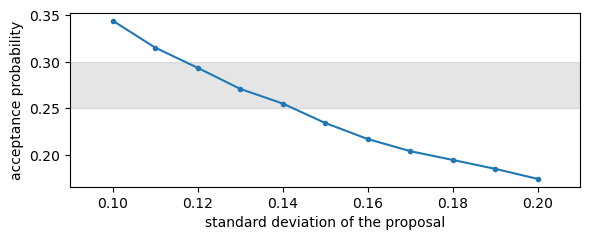

In [4]:
plt.figure(figsize=(6,2.5))
plt.fill_between([0, 0.5],[0.25, 0.25],[0.3, 0.3],color='grey',alpha=0.2)
plt.plot(std,acc_r, marker='.')
plt.ylabel('acceptance probability')
plt.xlabel('standard deviation of the proposal')
plt.xlim([0.09,0.21])
plt.tight_layout()
plt.savefig('tuning.png', dpi=300)

In [5]:
steps = 101_000
samples, probs, acc_rate = metropolis_hastings(steps,data,sigma=0.13, u0 = np.array([0,0])) # 0.13
print('acceptance rate:', acc_rate)

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_57274/4103580134.py:81: RuntimeWarning: overflow encountered in exp
  return np.exp(1/(2*sigma**2) * (-u_prop_sum + u_sum))


acceptance rate: 0.26921782178217823


In [6]:
# scale plots nicely to data
min_alpha = np.min(samples[:,0])
max_alpha = np.max(samples[:,0])
min_beta = np.min(samples[:,1])
max_beta = np.max(samples[:,1])
pad_alpha = 7-(max_alpha-min_alpha)
pad_beta = 7-(max_beta-min_beta)

N = 100
a = np.linspace(min_alpha-pad_alpha,max_alpha+pad_alpha,N)
b = np.linspace(min_beta-pad_beta,max_beta+pad_beta,N)
deterministic_out = np.zeros((N,N))

# calculate deterministic function values for background
for i in range(N):
    for j in range(N):
        deterministic_out[i,j] = determ(np.array([a[i],b[j]]))

A,B = np.meshgrid(a,b)

In [7]:
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = gaussian_kde(samples.T)
#xi, yi = np.mgrid[a.min():a.max():nbins*1j, b.min():b.max():nbins*1j]
xi, yi = np.mgrid[-0.5:1.5:nbins*1j, 4:6:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

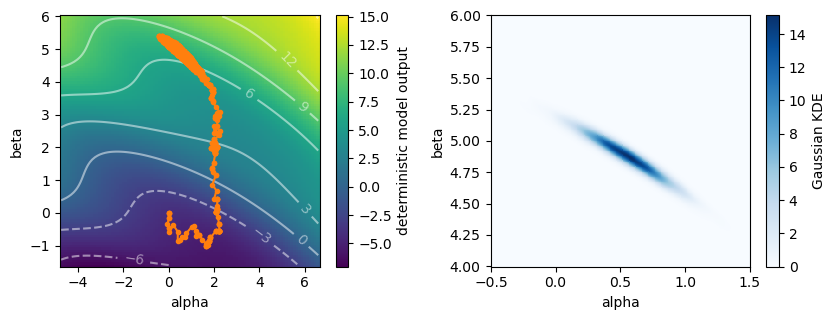

In [13]:
plt.figure(figsize=(8.5,3.3))

plt.subplot(1,2,1)
plt.pcolor(A,B,deterministic_out)
plt.colorbar(label = 'deterministic model output')
cont = plt.contour(A,B,deterministic_out, colors='w', alpha = 0.5)
plt.clabel(cont, inline=1, fontsize=10)
plt.plot(samples[:,0],samples[:,1], c='C1', marker='.')
plt.ylabel('beta')
plt.xlabel('alpha')

# zoomed in plot
plt.subplot(1,2,2)
plt.pcolor(xi, yi, zi.reshape(xi.shape), shading='auto',cmap='Blues')
plt.colorbar(label = 'Gaussian KDE')
plt.ylabel('beta')
plt.xlabel('alpha')
# plt.xlim([min_alpha2,max_alpha2])
# plt.ylim([min_beta2,max_beta2])

plt.tight_layout()
plt.savefig('MCMC_path.png', dpi=300)

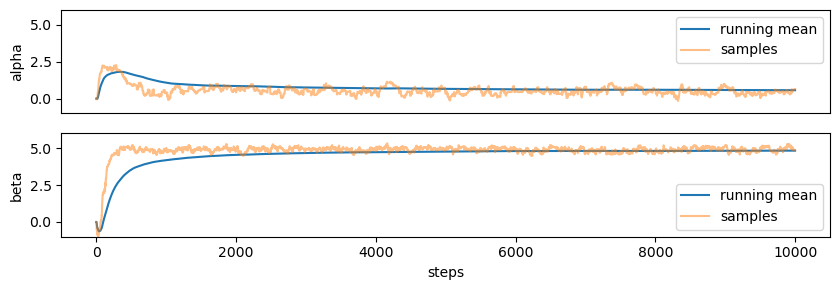

In [9]:
running_a = np.cumsum(samples[:,0])/np.arange(1,steps+2)
running_b = np.cumsum(samples[:,1])/np.arange(1,steps+2)

plt.figure(figsize=(8.5,3))
plt.subplot(2,1,1)
plt.plot(running_a[:5000], label='running mean')
plt.plot(samples[:5000,0], alpha = 0.5, label = 'samples')
plt.ylim([-1,6])
plt.ylabel('alpha')
plt.xticks([])
plt.legend()

plt.subplot(2,1,2)
plt.plot(running_b[:10_000], label='running mean')
plt.plot(samples[:10_000,1],alpha=0.5, label='samples')
plt.ylim([-1,6])
plt.ylabel('beta')
plt.xlabel('steps')
plt.legend()

plt.tight_layout()
plt.savefig('convergence.png', dpi=300)

In [10]:
# calulate the model output for the samples
mod_samp = np.zeros(len(samples))
for i, sample in enumerate(samples):
    mod_samp[i] = func(sample)

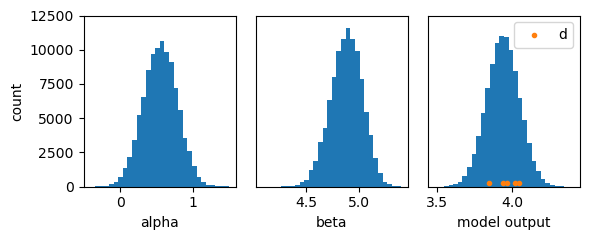

In [11]:
# plot the marignal distributions of alpha and beta
fig, axs = plt.subplots(1,3)
fig.set_size_inches(6,2.5)
axs[0].hist(samples[1000:,0],bins=30)
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('count')
axs[0].set_ylim([0,12_500])

axs[1].hist(samples[1000:,1],bins=30)
axs[1].set_xlabel('beta')
axs[1].set_ylim([0,12_500])
axs[1].set_yticks([])

axs[2].hist(mod_samp[1000:], bins=30)
axs[2].scatter(data, 300*np.ones_like(data),c='C1',marker='.', label = 'd')
axs[2].set_xlabel('model output')
axs[2].legend(loc='best')
axs[2].set_yticks([])
axs[2].set_ylim([0,12_500])

plt.tight_layout()
plt.savefig('marginals.png', dpi=300)

In [19]:
print('alpha mean:', samples[1000:,0].mean())
print('alpha std:', samples[1000:,0].std())
print('beta mean:', samples[1000:,1].mean())
print('beta std:', samples[1000:,1].std())
print('output mean:', mod_samp.mean())
print('output std:', mod_samp.std())

alpha mean: 0.5505868895548832
alpha std: 0.23576443290971819
beta mean: 4.880614587790156
beta std: 0.15120605712205248
output mean: 3.9399907241980414
output std: 0.12326739226525836


In [12]:
# covariance matrix for alpha and beta
np.cov(samples[1000:].T)

array([[ 0.05558542, -0.03445371],
       [-0.03445371,  0.0228635 ]])